Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb)

## Code Modules, Classes, & Functions

[GoogleColaboratory Variant](https://colab.research.google.com/drive/1OBmekkzdgivSLrJq_6HTtHZKc5ZNXbqX)

In [18]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [19]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [20]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break

In [21]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))
    

## Data

In [22]:
random_seed=12; batch_size=128
tr0=(.5); tr1=(.25); img_size=28
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr1)])
train_ids=torch.arange(0,54000)
valid_ids=torch.arange(54000,60000)
train_valid=tmnist(root='data',train=True,
                   download=True,transform=trans)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tmnist(root='data',train=False, 
            transform=trans)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


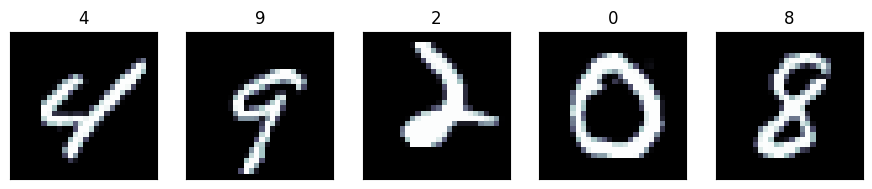

In [23]:
display_examples(valid_loader,img_size)

In [24]:
# Training & Validation set from LetterColorImages_123.h5
fpath = './dataset/'

f_trainval = h5py.File(fpath + 'LetterColorImages_123.h5', 'r')
keys = list(f_trainval.keys()); print("Train/Valid keys:", keys)
x_tv = 1 - np.array(f_trainval[keys[1]], dtype='float32') / 255
x_tv = timage.resize(x_tv, [img_size, img_size])
x_tv = (np.dot(x_tv.numpy(), [.299, .587, .114])).reshape(-1, 1, img_size, img_size)
y_tv = np.array(f_trainval[keys[2]], dtype='int32') - 1

N = len(y_tv); n = int(.1 * N)
shuffle_ids = np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x_tv, y_tv = x_tv[shuffle_ids], y_tv[shuffle_ids]
x_valid, x_train = x_tv[n:2*n], x_tv[2*n:]
y_valid, y_train = y_tv[n:2*n], y_tv[2*n:]
batch_size2 = 128

train2 = TData(x_train, y_train)
valid2 = TData(x_valid, y_valid)
train_loader2 = tdl(dataset=train2, shuffle=True, batch_size=batch_size)
valid_loader2 = tdl(dataset=valid2, shuffle=True, batch_size=batch_size)

# Test set from LetterColorImages.h5 (entire dataset)
f_test = h5py.File(fpath + 'LetterColorImages.h5', 'r')
keys_test = list(f_test.keys()); print("Test keys:", keys_test)
x_test = 1 - np.array(f_test[keys_test[1]], dtype='float32') / 255
x_test = timage.resize(x_test, [img_size, img_size])
x_test = (np.dot(x_test.numpy(), [.299, .587, .114])).reshape(-1, 1, img_size, img_size)
y_test = np.array(f_test[keys_test[2]], dtype='int32') - 1

test2 = TData(x_test, y_test)
test_loader2 = tdl(dataset=test2, shuffle=False, batch_size=batch_size)


Train/Valid keys: ['backgrounds', 'images', 'labels']
Test keys: ['backgrounds', 'images', 'labels']


Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


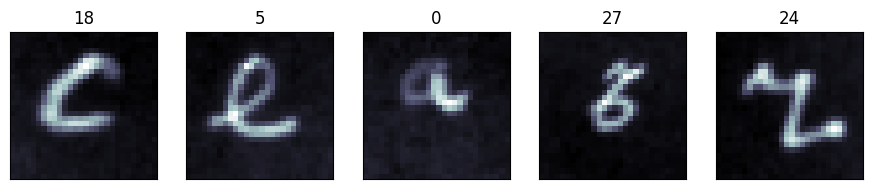

In [25]:
display_examples(valid_loader2,img_size)

## ResNet

In [26]:
def conv3x3(in_planes,out_planes,stride=1):
    return tnn.Conv2d(in_planes,out_planes,
                      kernel_size=3,stride=stride,
                      padding=1,bias=False)
class BasicBlock(tnn.Module):
    expansion=1
    def __init__(self,inplanes,planes,
                 stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1=conv3x3(inplanes,planes,stride)
        self.bn1=tnn.BatchNorm2d(planes)
        self.relu=tnn.ReLU(inplace=True)
        self.conv2=conv3x3(planes,planes)
        self.bn2=tnn.BatchNorm2d(planes)
        self.downsample=downsample
        self.stride=stride
    def forward(self,x):
        residual=x
        y=self.conv1(x); y=self.bn1(y)
        y=self.relu(y)
        y=self.conv2(y); y=self.bn2(y)
        if self.downsample is not None:
            residual=self.downsample(x)
        y+=residual
        y=self.relu(y)
        return y

In [27]:
class ResNet(tnn.Module):
    def __init__(self,block,layers,num_classes,grayscale):
        self.inplanes=64
        if grayscale: in_dim=1
        else: in_dim=3
        super(ResNet,self).__init__()
        self.conv1=tnn\
        .Conv2d(in_dim,64,kernel_size=7,stride=2,
                padding=3,bias=False)
        self.bn1=tnn.BatchNorm2d(64)
        self.relu=tnn.ReLU(inplace=True)
        self.maxpool=tnn\
        .MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,64,layers[0])
        self.layer2=self._make_layer(block,128,
                                     layers[1],stride=2)
        self.layer3=self._make_layer(block,256,
                                     layers[2],stride=2)
        self.layer4=self._make_layer(block,512,
                                     layers[3],stride=2)
        self.avgpool=tnn.AvgPool2d(7,stride=1)
        self.fc=tnn.Linear(512*block.expansion,num_classes)
        for m in self.modules():
            if isinstance(m,tnn.Conv2d):
                n=m.kernel_size[0]*m.kernel_size[1]*m.out_channels
                m.weight.data.normal_(0,(2./n)**.5)
            elif isinstance(m,tnn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self,block,planes,blocks,stride=1):
        downsample=None
        if stride!=1 or self.inplanes!=planes*block.expansion:
            downsample=tnn.Sequential(
                tnn.Conv2d(self.inplanes,planes*block.expansion,
                           kernel_size=1,stride=stride,bias=False),
                tnn.BatchNorm2d(planes*block.expansion))
        layers=[]
        layers.append(block(self.inplanes,planes,
                            stride,downsample))
        self.inplanes=planes*block.expansion
        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes))
        return tnn.Sequential(*layers)
    def forward(self,x):
        x=self.conv1(x); x=self.bn1(x)
        x=self.relu(x); x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
#        x=self.avgpool(x)        
        x=x.view(x.size(0),-1)
        logits=self.fc(x)
        probs=tnnf.softmax(logits,dim=1)
        return logits,probs
def ResNN(num_classes):
    model=ResNet(block=BasicBlock,layers=[2,2,2,2],
                num_classes=num_classes,
                grayscale=True)
    return model

## Training

In [28]:
# @register_line_magic
# def train_run(epochs):
#     epochs=int(epochs)
#     model.to(dev)  # Make sure model is on GPU
#     for epoch in range(epochs):
#         model.train()
#         for batch_ids,(features,targets) in enumerate(train_loader):        
#             features=features.to(dev); targets=targets.to(dev)
#             logits,probs=model(features)
#             cost=tnn.functional.cross_entropy(logits,targets)
#             optimizer.zero_grad(); cost.backward()
#             optimizer.step()
#             if not batch_ids%200:
#                 print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
#                        %(epoch+1,epochs,batch_ids, 
#                          len(train)//batch_size,cost))
#         model.eval()         
#         with torch.set_grad_enabled(False):
#             print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
#                   (epoch+1,epochs,
#                    model_acc(model,train_loader),
#                    model_acc(model,valid_loader)))

In [29]:
# torch.manual_seed(random_seed)
# num_classes=10; learning_rate=.001
# model=ResNN(num_classes)
# model.to(dev)
# optimizer=torch.optim.Adam(model.parameters(),
#                            lr=learning_rate)

In [30]:
# %train_run 55

In [31]:
#%print_acc 1

In [32]:
@register_line_magic
def train_run2(epochs):
    epochs = int(epochs)
    train_acc_list = []
    valid_acc_list = []

    for epoch in range(epochs):
        model.train()
        for batch_ids, (features, targets) in enumerate(train_loader2):        
            features = features.to(dev)
            targets = targets.to(dev)
            logits, probs = model(features)
            cost = tnn.functional.cross_entropy(logits, targets.long())
            optimizer2.zero_grad()
            cost.backward()
            optimizer2.step()

            if not batch_ids % 50:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                      % (epoch+1, epochs, batch_ids, 
                         len(train2)//batch_size2, cost))

        # Evaluation after each epoch
        model.eval()         
        with torch.set_grad_enabled(False):
            train_acc = model_acc(model, train_loader2)
            valid_acc = model_acc(model, valid_loader2)
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%' %
                  (epoch+1, epochs, train_acc, valid_acc))

    # Plotting after training ends
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, epochs+1), valid_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [33]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.001
model=ResNN(num_classes)
model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

Epoch: 001/125 | Batch 000/088 | Cost: 3.8084
Epoch: 001/125 | Batch 050/088 | Cost: 2.2569
Epoch: 001/125 train acc: 35.41% valid acc: 32.98%
Epoch: 002/125 | Batch 000/088 | Cost: 1.6175
Epoch: 002/125 | Batch 050/088 | Cost: 1.1198
Epoch: 002/125 train acc: 43.31% valid acc: 41.37%
Epoch: 003/125 | Batch 000/088 | Cost: 0.6785
Epoch: 003/125 | Batch 050/088 | Cost: 0.6835
Epoch: 003/125 train acc: 68.16% valid acc: 66.17%
Epoch: 004/125 | Batch 000/088 | Cost: 0.7219
Epoch: 004/125 | Batch 050/088 | Cost: 0.5401
Epoch: 004/125 train acc: 75.24% valid acc: 70.89%
Epoch: 005/125 | Batch 000/088 | Cost: 0.4507
Epoch: 005/125 | Batch 050/088 | Cost: 0.3338
Epoch: 005/125 train acc: 61.47% valid acc: 56.66%
Epoch: 006/125 | Batch 000/088 | Cost: 0.3299
Epoch: 006/125 | Batch 050/088 | Cost: 0.4520
Epoch: 006/125 train acc: 70.37% valid acc: 65.05%
Epoch: 007/125 | Batch 000/088 | Cost: 0.2746
Epoch: 007/125 | Batch 050/088 | Cost: 0.4419
Epoch: 007/125 train acc: 85.60% valid acc: 79.07%

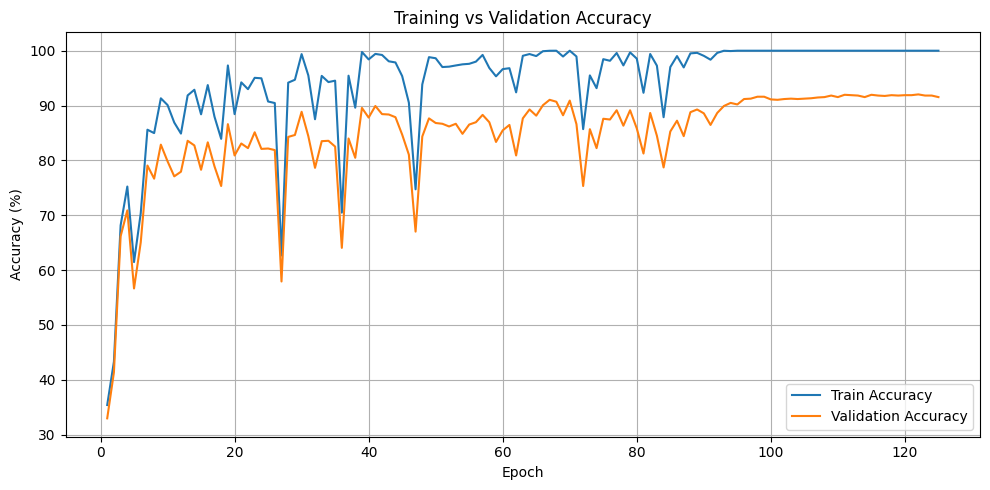

In [34]:
%train_run2 125

In [35]:
%print_acc 2

Train accuracy: 100.0000%
Valid accuracy: 91.5433%
Test accuracy: 95.0303%
